# The MRSAA-c Component
A notebook tutorial of the MRSAA-c landlab component

**Made by Sergio Villamarin**

### Setup

Our MRSAA-c implementation is done on Landlab's Network Model Grid (NMG), you can think of it as a graph. So let's see a quick example of this

<Axes: xlabel='x', ylabel='y'>

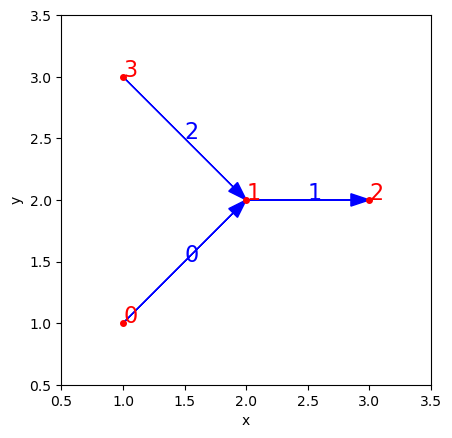

In [13]:
from landlab import NetworkModelGrid
import landlab.plot.graph as graph

x_of_nodes = [1, 1, 2, 3]
y_of_nodes = [3, 1, 2, 2]
links = [(0,2) ,(1,2), (2,3)]

ngrid = NetworkModelGrid((y_of_nodes, x_of_nodes), links)
graph.plot_graph(ngrid, at="node,link", with_id=True)


This allows us to represent river networks and run processes exclusive to them on this grid. In practice we use topographic data which is usually read as a Raster file (equally spaced 2D grid of topographic elevation). For now we will use the following single channel generated raster

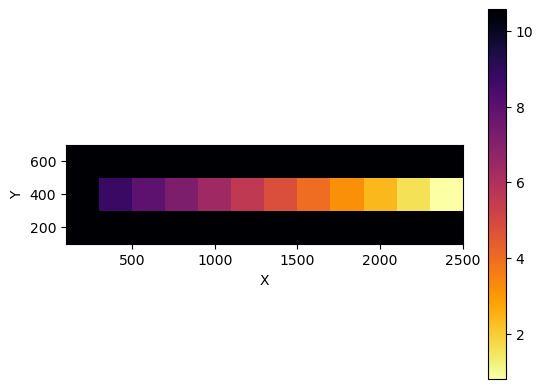

In [14]:
from landlab import imshow_grid
from landlab.io import read_esri_ascii
# store it as a raster file
rastergrid, topography = read_esri_ascii("short_reach.asc")
rastergrid.add_field("topographic__elevation", topography)
imshow_grid(rastergrid, rastergrid.at_node["topographic__elevation"], cmap='inferno_r')

we can then use landlab's function ```network_grid_from_raster``` to create a NMG (hard to see well but you can see the nodes and the arrows indices on it)

<Axes: xlabel='x', ylabel='y'>

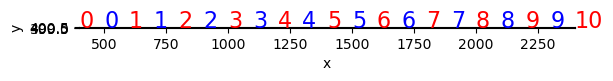

In [15]:
from landlab.grid.create_network import network_grid_from_raster

ngrid = network_grid_from_raster(rastergrid)
graph.plot_graph(ngrid, at="node,link", with_id=True)

Now we need to set up the parameters of the network and sediment. For now we will use default values. Additionally we need the direction of the flow as a ```FlowDirector``` object

In [16]:
from landlab.components import Componentcita as comp
from landlab.components import FlowDirectorSteepest

comp.Componentcita._preset_fields(ngrid=ngrid)
flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()

And finally create an instance of our component

In [17]:
nety = comp.Componentcita(ngrid, flow_director)

The shape of this specific network is a line so we can plot its field values in a fairly simple way, let's start by plotting the topography again

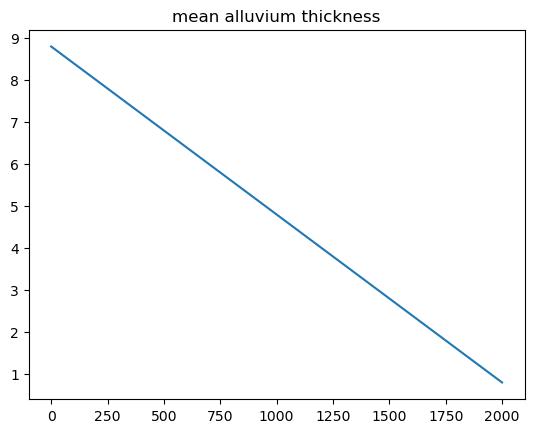

In [18]:
import matplotlib.pyplot as plt
import numpy as np
YEAR = 365.25 * 24 * 60 * 60

# x values are distance downstream (going from left to right)
xs = np.cumsum(ngrid.at_node["reach_length"])
xs = xs - xs[0]
# y can be any grid landlab fields
ys = ngrid.at_node["topographic__elevation"]
plt.plot(xs, ys, label="initial")
plt.title("mean alluvium thickness")
ax = plt.gca()
fig = plt.gcf()


Now let's see how the alluvium changes as we let the model run for a year with a constant sediment flux at the upstream end

In [19]:
# Run the model for a year
dt = YEAR/1000
for _ in range(1000):
    nety.run_one_step(dt=dt, q_in=0.000834)

# plot the new alluvium
ys = ngrid.at_node["mean_alluvium_thickness"]
ax.plot(xs, ys, label="a year after")
plt.show(fig)

In [20]:
%matplotlib inline
fig = plt.gcf()
plt.show(fig)

<Figure size 640x480 with 0 Axes>

In [21]:
print(ngrid["node"].keys())

['flow__link_to_receiver_node', 'drainage_area', 'flood_status_code', 'flow__data_structure_delta', 'topographic__steepest_slope', 'topographic__elevation', 'flow__receiver_node', 'depression__outlet_node', 'water__unit_flux_in', 'is_pit', 'flow__upstream_node_order', 'surface_water__discharge', 'depression__depth', 'discharge', 'flood_intermittency', 'channel_width', 'sediment_grain_size', 'macroroughness', 'flow__sink_flag', 'bedrock', 'flow__sender_node', 'reach_length', 'fraction_alluvium_cover', 'fraction_alluvium_avaliable', 'sed_capacity', 'mean_alluvium_thickness', 'channel_slope']


In [22]:
ys

array([ 0.52755296,  0.52755238,  0.52755069,  0.52754988,  0.52754839,
        0.52754621,  0.5275431 ,  0.52753885,  0.52753327,  0.52752631,
        0.52751819])

['short_reach.asc']

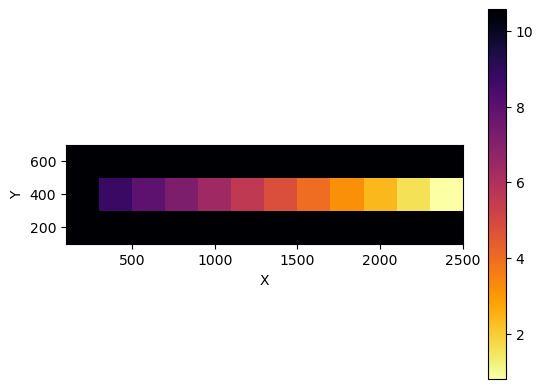

In [23]:
# if I want to generate a longer reach, other than that this codeblock can be ignored
# grid parameters
from landlab.io.esri_ascii import write_esri_ascii
from landlab.grid import RasterModelGrid
from landlab import imshow_grid

reach_lenght = 200
total_length = 2000 + reach_lenght
slope = 0.004
steepness = slope * reach_lenght
# grid geometry creation
n = round(total_length / reach_lenght)
shape = (3, n + 1)
cliff_height = steepness * n * 1.2 + 0.01
topography = [cliff_height] * (3 * (n+1))
# create the grid
for i in range(n):
    topography[n + i + 2] = steepness * (n - i)

raster2save = RasterModelGrid(shape, reach_lenght, (200, 200))
raster2save.add_field("topographic__elevation", topography)
imshow_grid(raster2save, raster2save.at_node["topographic__elevation"], cmap='inferno_r')
write_esri_ascii("short_reach.asc", raster2save, clobber=True)